In [3]:
# %load D:/BUDS_MID/__init__.py
"""
Created on Wed Feb 19 16:21:00 2020

@author: cmchico

usual imports
"""

import os
import pandas as pd
import numpy as np

pd.options.display.max_rows = 100
pd.set_option('display.float_format', '{:.0f}'.format)

from time import time
from datetime import timedelta

import pickle

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [19]:
# %load D:/BUDS_MID/__initdask__.py
"""
Created on Wed Feb 19 16:24:03 2020

@author: cmchico
"""
import dask.bag as db
from dask.distributed import Client, progress
from dask import delayed

client = Client(processes = True,n_workers=12)
client

'\nCreated on Wed Feb 19 16:24:03 2020\n\n@author: cmchico\n'

C:\ProgramData\Anaconda3\lib\site-packages\distributed\bokeh\core.py:57: UserWarning: 
Port 8787 is already in use. 
Perhaps you already have a cluster running?
Hosting the diagnostics dashboard on a random port instead.
  warnings.warn('\n' + msg)


Client Scheduler: tcp://127.0.0.1:51910 Dashboard: http://127.0.0.1:51913/status,Cluster Workers: 12 Cores: 12 Memory: 34.14 GB


In [3]:
#THIS WILL WORK ONLY FOR 2017
tid_list = pd.read_csv('tid_list.csv')
tid_list.columns = ['index','tid']
tid_list = tid_list.tid.astype(str).str.zfill(4).values

In [66]:
out = "D:/BUDS OUT/ATM TSR/"

#Business Rules:
offus = {'BN':'OffUs',
         'SA':'OnUs',
         'VS':'OffUs', 
         'CA':'OnUs',
         'FB':'OnUs',
         'CC':'OnUs', 
         'MD':'OffUs', 
         'EC':'OnUs', 
         'BP':'OffUs'}

valid_stat = [0,400]
valid_tran = ['WDL','ADV','REV']

#GENERALLY, 400,REV is subtracted from approved withdrawals, but not always. ~for 2019
#There are cases where the total withdrawals will be negative -- some reversals should not be subtracted
#which will show negative amounts
#SEE:
#91016880	0	-17600	0	3	-17600	3	2018-10-21	ATMTSR_october 21.pkl
#This is a risk that is accepted as there is no way to determine except to manually check. 

# Total Withdrawals for current day
# = '0,WDL' + '0,ADV' - '400,REV' , all amounts should be <=40000
# from 10PM the day before until 10PM current day 

In [19]:
def prep_tsr_pkl(path):
    df = pd.read_pickle(path)
    df.rename(columns={'AMOUNT':'AMT'},inplace=True)
    
    df = df[['DATE','TID', 'TRAN_CODE', 'APPL_CODE', 'AMT','STATUS_COD','SEQ']].copy()
    df.STATUS_COD = df.STATUS_COD.fillna("999").astype(int)

    df['OffUsFlag'] = df.APPL_CODE.map(offus)
    
    df['TID_SEQ'] = df.TID + '_' + df.SEQ.astype('str')
    
    Include_WDL = (df.TRAN_CODE.isin(['WDL','ADV'])) & (df.STATUS_COD == 0) & (df.AMT <=40000)
#Ensure that we only get REVs with corresponding successful withdrawals, usually REV is with same seq as WDL
    Include_REV = (df.TRAN_CODE == 'REV') & (df.STATUS_COD == 400) \
                    & (df.AMT <=40000)
#                     & (df.TID_SEQ.isin(df[Include_WDL].TID_SEQ))
    
    Include_TID = (df.TID.str[:4].isin(['9101','9000'])) & (df.TID.str[4:].isin(tid_list))
    
    df.TID = '9101' + df.TID.str[4:]
    df['AMT_Sign'] = df['AMT'].fillna(0)

    select = df.TRAN_CODE == 'REV'
    df.loc[select,'AMT_Sign'] = df.loc[select,'AMT_Sign']*(-1)

# #     summ = df[(Include_Stat) & (Include_Tran)
    summ = df[((Include_REV) | (Include_WDL))
             &(Include_TID) 
             ].pivot_table(columns=['OffUsFlag'],
                           values=['AMT_Sign'],
                           index=['TID'],
                           aggfunc=['sum','count']).fillna(0)

    
    
#     Include_Stat = df.STATUS_COD.isin(valid_stat).values
#     Include_Tran = df.TRAN_CODE.isin(valid_tran).values
#     Include_TID = df.TID.str[:4] == '9101'
    
#     df['AMT_Sign'] = df['AMT'].fillna(0)

#     select = df.TRAN_CODE == 'REV'
#     df.loc[select,'AMT_Sign'] = df.loc[select,'AMT_Sign']*(-1)

#     summ = df[(Include_Stat) & (Include_Tran)
#              &(Include_TID) 
#              ].pivot_table(columns=['OffUsFlag'],
#                                                                            values=['AMT_Sign'],
#                                                                            index=['TID'],
#                                                                            aggfunc=['sum','count']).fillna(0)

    summ.columns = ['WDL_AMT_OFFUS', 'WDL_AMT_ONUS','WDL_COUNT_OFFUS','WDL_COUNT_ONUS']

    summ['WDL_AMT'] = summ.WDL_AMT_OFFUS + summ.WDL_AMT_ONUS
    summ['WDL_COUNT'] = summ.WDL_COUNT_OFFUS + summ.WDL_COUNT_ONUS
    
    summ['DATE'] = pd.to_datetime(df.DATE.mode()[0])

    return summ

In [20]:
path = 'D:/BUDS_MID/ATM Forecasting/Mid/ATM TSR/2019'
dbpath = db.from_sequence([path + '/'+ i for i in os.listdir(path)])
dbmaster = dbpath.map(prep_tsr_pkl)

In [21]:
start=time()
df = dbmaster.compute()
fin = pd.concat(df[i].assign(file=os.listdir(path)[i]) for i in range(len(os.listdir(path)))).reset_index()
fin.to_pickle(out+'ATMTSR_2019_WDL.pkl')
print(timedelta(seconds=time()-start))

0:06:24.478268


In [22]:
fin.WDL_AMT.describe(percentiles=np.array(range(0,100,5))/100)

count    255944
mean    1041574
std      700621
min           0
0%            0
5%       108200
10%      224600
15%      329800
20%      428400
25%      520100
30%      609200
35%      694400
40%      778600
45%      859100
50%      942600
55%     1026900
60%     1116200
65%     1209200
70%     1312700
75%     1429400
80%     1564000
85%     1731700
90%     1961800
95%     2332300
max     8167600
Name: WDL_AMT, dtype: float64

In [34]:
path = 'D:/BUDS_MID/ATM Forecasting/Mid/ATM TSR/2018'
dbpath = db.from_sequence([path + '/'+ i for i in os.listdir(path)])
dbmaster = dbpath.map(prep_tsr_pkl)

In [24]:
start=time()
df = dbmaster.compute()
fin = pd.concat(df[i].assign(file=os.listdir(path)[i]) for i in range(len(os.listdir(path)))).reset_index()
fin.to_pickle(out+'ATMTSR_2018_WDL.pkl')
print(timedelta(seconds=time()-start))

0:15:56.182723


In [25]:
fin.WDL_AMT.describe(percentiles=np.array(range(0,100,5))/100)

count    794963
mean    1034183
std      707436
min      -17600
0%       -17600
5%       114400
10%      229100
15%      332500
20%      426900
25%      515100
30%      598500
35%      679600
40%      759700
45%      840000
50%      920800
55%     1004400
60%     1093000
65%     1188000
70%     1292100
75%     1411000
80%     1550700
85%     1724600
90%     1961800
95%     2350100
max     8981900
Name: WDL_AMT, dtype: float64

In [39]:
path = 'D:/BUDS_MID/ATM Forecasting/Mid/ATM TSR/2017'
dbpath = db.from_sequence([path + '/'+ i for i in os.listdir(path)])
dbmaster = dbpath.map(prep_tsr_pkl_2017)

In [40]:
start=time()
df = dbmaster.compute()
fin = pd.concat(df[i].assign(file=os.listdir(path)[i]) for i in range(len(os.listdir(path)))).reset_index()
fin.to_pickle(out+'ATMTSR_2017_WDL.pkl')
print(timedelta(seconds=time()-start))

0:11:11.698915


In [41]:
fin.WDL_AMT.describe(percentiles=np.array(range(0,100,5))/100)

count    782047
mean     926632
std      670774
min      -10000
0%       -10000
5%        91700
10%      186600
15%      274700
20%      356400
25%      434000
30%      509000
35%      582700
40%      655900
45%      729500
50%      805500
55%      883600
60%      967200
65%     1057000
70%     1155900
75%     1269100
80%     1402000
85%     1568900
90%     1801540
95%     2189000
max     8308000
Name: WDL_AMT, dtype: float64

In [45]:
fin[fin.WDL_AMT > 8000000]

,TID,WDL_AMT_OFFUS,WDL_AMT_ONUS,WDL_COUNT_OFFUS,WDL_COUNT_ONUS,WDL_AMT,WDL_COUNT,DATE,file
466751,91019528,83500,8224500,11,1102,8308000,1113,2017-08-10,ATMTSR_08 august 2017 _august 10.pkl
709784,91017920,27900,8189100,10,1074,8217000,1084,2017-11-29,ATMTSR_11 november 2017 _november 29.pkl


### Prep New Data 

In [1]:
raw = 'D:/BUDS/ATM Daily Withdrawals/'

In [55]:
@delayed
def prep_amt(year):
    df = pd.read_excel(raw+'Amout and Vol per TID '+year+'.xlsx', sheet_name='Amount') \
                .assign(file='Amout and Vol per TID '+year+'.xlsx')

    df = df[df.Type=='ATM']
    df['DATE'] = pd.to_datetime(df.Date)
    df.rename(columns={'Withdrawal':'WDL_AMT',
                          'Off Us Withdrawal':'WDL_AMT_OFFUS',
                          }, inplace=True)
    df['WDL_AMT_ONUS'] = df.WDL_AMT - df.WDL_AMT_OFFUS
    df['TID'] = df[[col for col in  df.columns if 'TID' in col][0]]
    return df[['TID','DATE','WDL_AMT','WDL_AMT_ONUS','WDL_AMT_OFFUS']]

@delayed
def prep_count(year):
    df= pd.read_excel(raw+'Amout and Vol per TID ' + year+ '.xlsx', sheet_name='Count') \
                .assign(file='Amout and Vol per TID ' + year+ '.xlsx')

    df = df[df.Type=='ATM']
    df['DATE'] = pd.to_datetime(df.Date)
    df.rename(columns={'Withdrawal':'WDL_COUNT',
                      'Off-us':'WDL_COUNT_OFFUS',
                      }, inplace=True)

    df['WDL_COUNT_ONUS'] = df.WDL_COUNT - df.WDL_COUNT_OFFUS
    df['TID'] = df[[col for col in  df.columns if 'TID' in col][0]]
    return df[['TID','DATE','WDL_COUNT','WDL_COUNT_ONUS','WDL_COUNT_OFFUS']]
#     return df

In [56]:
start = time()
df = prep_count('2019').compute()
print(timedelta(seconds=time()-start))

0:03:21.945005


In [57]:
df_amt = delayed(pd.concat)([prep_amt('2019'),prep_amt('2020')])
df_count = delayed(pd.concat)([prep_count('2019'),prep_count('2020')])

In [58]:
df = df_amt.merge(df_count, on=['TID','DATE'], how='outer')

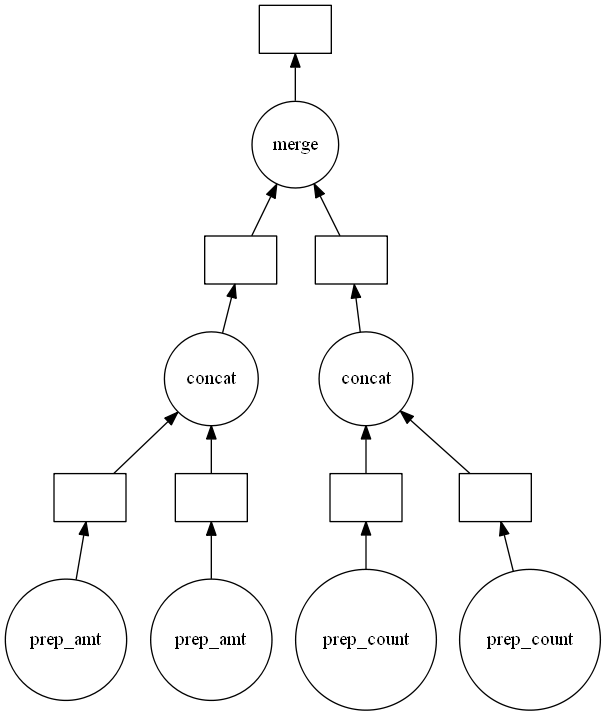

In [59]:
df.visualize()

In [60]:
start=time()
fin = df.compute()
print(timedelta(seconds=time()-start))

0:03:38.144432


In [63]:
fin.info()
fin[fin.WDL_AMT.isnull()]

<class 'pandas.core.frame.DataFrame'>
Int64Index: 951010 entries, 0 to 951009
Data columns (total 8 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   TID              951010 non-null  int64         
 1   DATE             951010 non-null  datetime64[ns]
 2   WDL_AMT          950991 non-null  float64       
 3   WDL_AMT_ONUS     950991 non-null  float64       
 4   WDL_AMT_OFFUS    950991 non-null  float64       
 5   WDL_COUNT        950978 non-null  float64       
 6   WDL_COUNT_ONUS   950978 non-null  float64       
 7   WDL_COUNT_OFFUS  950978 non-null  float64       
dtypes: datetime64[ns](1), float64(6), int64(1)
memory usage: 65.3 MB


,TID,DATE,WDL_AMT,WDL_AMT_ONUS,WDL_AMT_OFFUS,WDL_COUNT,WDL_COUNT_ONUS,WDL_COUNT_OFFUS
950991,91010305,2019-03-07,nan,nan,nan,25,19,6
950992,91010491,2019-03-07,nan,nan,nan,57,56,1
950993,91015130,2019-03-07,nan,nan,nan,61,30,31
950994,91015162,2019-03-07,nan,nan,nan,13,8,5
950995,91016126,2019-03-07,nan,nan,nan,23,18,5
950996,91016934,2019-03-07,nan,nan,nan,23,23,0
950997,91017797,2019-03-07,nan,nan,nan,133,60,73
950998,91017862,2019-03-07,nan,nan,nan,34,28,6
950999,91017894,2019-03-07,nan,nan,nan,6,2,4
951000,91018144,2019-03-07,nan,nan,nan,276,239,37


NameError: name 'fin' is not defined

In [64]:
# after investigation, that is actually the case

In [69]:
fin.to_pickle(out+'ATMTSR_2019_2020_WDL.pkl')

### Investigate

##### 2018

#####  Investigate Multiple Files

    Conclusion: 
    ATMTSR_may 07e.pkl only contains withdrawals should be excluded, keep ATMTSR_may 07.pkl
    ATMTSR_june 20.pkl - CARD_NO is not given for most, account number not given in some. Seems to be corrected
        in ATMTSR_june 20r.pkl <- keep this
    ATMTSR_june 21e.pkl only contains withdrawals should be excluded, keep ATMTSR_june 21.pkl
    
    
    If 'e' <- contains only Withdrawals, exclude

In [80]:
df = pd.read_pickle(out+'ATMTSR_2018_WDL.pkl')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 831051 entries, 0 to 831050
Data columns (total 8 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   TID              831051 non-null  object        
 1   WDL_AMT_OFFUS    831051 non-null  float64       
 2   WDL_AMT_ONUS     831051 non-null  float64       
 3   WDL_COUNT_OFFUS  831051 non-null  float64       
 4   WDL_COUNT_ONUS   831051 non-null  float64       
 5   WDL_AMT          831051 non-null  float64       
 6   WDL_COUNT        831051 non-null  float64       
 7   DATE             831051 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(6), object(1)
memory usage: 50.7+ MB


In [89]:
df[(df.TID=='91010055') & (df.DATE == pd.to_datetime('2018-05-05'))]

,TID,WDL_AMT_OFFUS,WDL_AMT_ONUS,WDL_COUNT_OFFUS,WDL_COUNT_ONUS,WDL_AMT,WDL_COUNT,DATE
559209,91010055,380100,1026900,66,122,1407000,188,2018-05-05
565920,91010055,1704000,2926900,177,364,4630900,541,2018-05-05


In [127]:
other = pd.read_pickle(path+'/ATMTSR_may 07e.pkl')
other.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1151903 entries, 0 to 1151902
Data columns (total 16 columns):
 #   Column      Non-Null Count    Dtype  
---  ------      --------------    -----  
 0   DATE        1151903 non-null  object 
 1   TID         1151903 non-null  object 
 2   TIME        1151903 non-null  object 
 3   CARD_NO     1151903 non-null  object 
 4   JAI         1151903 non-null  float64
 5   TRAN_CODE   1151903 non-null  object 
 6   APPL_CODE   1151903 non-null  object 
 7   ACCOUNT_NU  1129251 non-null  float64
 8   AMOUNT      1151903 non-null  float64
 9   CTR1        1151903 non-null  float64
 10  CTR2        1151903 non-null  float64
 11  CTR3        1151903 non-null  float64
 12  CTR4        1151903 non-null  float64
 13  STATUS_COD  1151903 non-null  float64
 14  RI          1151903 non-null  object 
 15  SEQ         1151903 non-null  float64
dtypes: float64(9), object(7)
memory usage: 140.6+ MB


In [128]:
other.DATE.value_counts()

2018-05-05    439940
2018-05-07    393155
2018-05-06    304251
2018-05-04     14557
Name: DATE, dtype: int64

In [129]:
other.TRAN_CODE.unique()
# [may7.DATE.astype('str') == '2018-05-05'].TRAN_CODE.unique()

array(['WDL', 'ADV'], dtype=object)

In [141]:
other = pd.read_pickle(path+'/ATMTSR_june 20r.pkl').assign(file='june 20r')
other.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1141988 entries, 0 to 1141987
Data columns (total 17 columns):
 #   Column      Non-Null Count    Dtype  
---  ------      --------------    -----  
 0   DATE        1141988 non-null  object 
 1   TID         1141988 non-null  object 
 2   TIME        1141988 non-null  object 
 3   CARD_NO     1141988 non-null  object 
 4   JAI         1141988 non-null  float64
 5   TRAN_CODE   1141988 non-null  object 
 6   APPL_CODE   1141988 non-null  object 
 7   ACCOUNT_NU  953112 non-null   float64
 8   AMOUNT      1141988 non-null  float64
 9   CTR1        1141988 non-null  float64
 10  CTR2        1141988 non-null  float64
 11  CTR3        1141988 non-null  float64
 12  CTR4        1141988 non-null  float64
 13  STATUS_COD  1141988 non-null  float64
 14  RI          1141988 non-null  object 
 15  SEQ         1141988 non-null  float64
 16  file        1141988 non-null  object 
dtypes: float64(9), object(8)
memory usage: 148.1+ MB


In [133]:
other.DATE.value_counts()

2018-06-20    1141988
Name: DATE, dtype: int64

In [136]:
other.head()

,DATE,TID,TIME,CARD_NO,JAI,TRAN_CODE,APPL_CODE,ACCOUNT_NU,AMOUNT,CTR1,CTR2,CTR3,CTR4,STATUS_COD,RI,SEQ
0,2018-06-20,91010003,07:17A,00004162950102346840,4,WDL,BN,1,12000,0,0,0,0,128,0000,2795
1,2018-06-20,91010003,07:18A,00004162950102346840,4,WDL,BN,1,12000,0,0,0,0,128,0000,2796
2,2018-06-20,91010003,07:18A,00004162950102497296,9,INQ,BN,3,0,0,0,0,0,119,0000,2797
3,2018-06-20,91010003,07:19A,00004162950102497296,9,INQ,BN,1,0,0,0,0,0,128,0000,2798
4,2018-06-20,91010003,07:40A,00536347002239014500,0,OAR,,nan,0,0,0,0,0,911,0000,2799


In [142]:
orig = pd.read_pickle(path+'/ATMTSR_june 20.pkl').assign(file='june 20')
orig.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1148981 entries, 0 to 1148980
Data columns (total 17 columns):
 #   Column      Non-Null Count    Dtype  
---  ------      --------------    -----  
 0   DATE        1148981 non-null  object 
 1   TID         1148981 non-null  object 
 2   TIME        1148981 non-null  object 
 3   CARD_NO     1148981 non-null  object 
 4   JAI         1141988 non-null  float64
 5   TRAN_CODE   1148981 non-null  object 
 6   APPL_CODE   1148981 non-null  object 
 7   ACCOUNT_NU  952170 non-null   float64
 8   AMOUNT      1141988 non-null  float64
 9   CTR1        1141988 non-null  float64
 10  CTR2        1141988 non-null  float64
 11  CTR3        1141988 non-null  float64
 12  CTR4        1141988 non-null  float64
 13  STATUS_COD  1148981 non-null  float64
 14  RI          1148981 non-null  object 
 15  SEQ         1141988 non-null  float64
 16  file        1148981 non-null  object 
dtypes: float64(9), object(8)
memory usage: 149.0+ MB


In [189]:
print(f"orig:{orig.shape} \n other:{other.shape}"
    )
for col in orig.columns:
    print(f"""
    {col}
    orig = {orig[col].nunique()}
    other = {other[col].nunique()}
    """
         )


orig:(1148981, 17) 
 other:(1141988, 17)

    DATE
    orig = 1
    other = 1
    

    TID
    orig = 2967
    other = 2967
    

    TIME
    orig = 1094
    other = 1092
    

    CARD_NO
    orig = 50
    other = 482795
    

    JAI
    orig = 1
    other = 10
    

    TRAN_CODE
    orig = 10
    other = 10
    

    APPL_CODE
    orig = 10
    other = 10
    

    ACCOUNT_NU
    orig = 454750
    other = 455327
    

    AMOUNT
    orig = 12752
    other = 3234
    

    CTR1
    orig = 1
    other = 1
    

    CTR2
    orig = 1
    other = 1
    

    CTR3
    orig = 1
    other = 1
    

    CTR4
    orig = 1
    other = 1
    

    STATUS_COD
    orig = 43
    other = 43
    

    RI
    orig = 1006
    other = 6
    

    SEQ
    orig = 554942
    other = 10000
    

    file
    orig = 1
    other = 1
    


In [194]:
orig.columns

Index(['DATE', 'TID', 'TIME', 'CARD_NO', 'JAI', 'TRAN_CODE', 'APPL_CODE',
       'ACCOUNT_NU', 'AMOUNT', 'CTR1', 'CTR2', 'CTR3', 'CTR4', 'STATUS_COD',
       'RI', 'SEQ', 'file'],
      dtype='object')

In [199]:
keepme = ['DATE', 'TID', 'TIME', 'TRAN_CODE', 'APPL_CODE', 'AMOUNT', 'STATUS_COD',
       'RI']
pd.concat([orig,other]).drop_duplicates(subset=keepme,keep=False).sort_values(['TID','TIME']).head(100)

,DATE,TID,TIME,CARD_NO,JAI,TRAN_CODE,APPL_CODE,ACCOUNT_NU,AMOUNT,CTR1,CTR2,CTR3,CTR4,STATUS_COD,RI,SEQ,file
869488,2018-06-20,00001010,1010MD,,nan,,,nan,nan,nan,nan,nan,nan,0,002,nan,june 20
869528,2018-06-20,00001010,1010MD,,nan,,,nan,nan,nan,nan,nan,nan,0,003,nan,june 20
869568,2018-06-20,00001010,1010MD,,nan,,,nan,nan,nan,nan,nan,nan,0,004,nan,june 20
869608,2018-06-20,00001010,1010MD,,nan,,,nan,nan,nan,nan,nan,nan,0,005,nan,june 20
869648,2018-06-20,00001010,1010MD,,nan,,,nan,nan,nan,nan,nan,nan,0,006,nan,june 20
869688,2018-06-20,00001010,1010MD,,nan,,,nan,nan,nan,nan,nan,nan,0,007,nan,june 20
869728,2018-06-20,00001010,1010MD,,nan,,,nan,nan,nan,nan,nan,nan,0,008,nan,june 20
869768,2018-06-20,00001010,1010MD,,nan,,,nan,nan,nan,nan,nan,nan,0,009,nan,june 20
869808,2018-06-20,00001010,1010MD,,nan,,,nan,nan,nan,nan,nan,nan,0,010,nan,june 20
869848,2018-06-20,00001010,1010MD,,nan,,,nan,nan,nan,nan,nan,nan,0,011,nan,june 20


In [201]:
orig = pd.read_pickle(path+'/ATMTSR_june 21.pkl').assign(file='june 21')
orig.info()

other = pd.read_pickle(path+'/ATMTSR_june 21e.pkl').assign(file='june 21e')
other.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1004358 entries, 0 to 1004357
Data columns (total 17 columns):
 #   Column      Non-Null Count    Dtype  
---  ------      --------------    -----  
 0   DATE        1004358 non-null  object 
 1   TID         1004358 non-null  object 
 2   TIME        1004358 non-null  object 
 3   CARD_NO     1004358 non-null  object 
 4   JAI         1003937 non-null  float64
 5   TRAN_CODE   1004358 non-null  object 
 6   APPL_CODE   1004358 non-null  object 
 7   ACCOUNT_NU  850173 non-null   float64
 8   AMOUNT      1003937 non-null  float64
 9   CTR1        1003937 non-null  float64
 10  CTR2        1003937 non-null  float64
 11  CTR3        1003937 non-null  float64
 12  CTR4        1003937 non-null  float64
 13  STATUS_COD  1004358 non-null  float64
 14  RI          1004358 non-null  object 
 15  SEQ         1003937 non-null  float64
 16  file        1004358 non-null  object 
dtypes: float64(9), object(8)
memory usage: 130.3+ MB
<class 'pandas.c

In [202]:
print(f"orig:{orig.shape} \n other:{other.shape}"
    )
for col in orig.columns:
    print(f"""
    {col}
    orig = {orig[col].nunique()}
    other = {other[col].nunique()}
    """
         )


orig:(1004358, 17) 
 other:(353193, 17)

    DATE
    orig = 2
    other = 2
    

    TID
    orig = 2960
    other = 2238
    

    TIME
    orig = 1423
    other = 1395
    

    CARD_NO
    orig = 483483
    other = 311350
    

    JAI
    orig = 10
    other = 10
    

    TRAN_CODE
    orig = 10
    other = 2
    

    APPL_CODE
    orig = 10
    other = 8
    

    ACCOUNT_NU
    orig = 430171
    other = 306982
    

    AMOUNT
    orig = 12734
    other = 234
    

    CTR1
    orig = 1
    other = 1
    

    CTR2
    orig = 1
    other = 1
    

    CTR3
    orig = 1
    other = 1
    

    CTR4
    orig = 1
    other = 1
    

    STATUS_COD
    orig = 43
    other = 1
    

    RI
    orig = 353
    other = 1
    

    SEQ
    orig = 491883
    other = 261621
    

    file
    orig = 1
    other = 1
    


In [206]:
other.TRAN_CODE.value_counts()

WDL    351838
ADV      1355
Name: TRAN_CODE, dtype: int64

##### 2017

In [33]:
fin[fin.WDL_AMT<0].describe()

,WDL_AMT_OFFUS,WDL_AMT_ONUS,WDL_COUNT_OFFUS,WDL_COUNT_ONUS,WDL_AMT,WDL_COUNT
count,52,52,52,52,52,52
mean,-58,-8833,1,12,-8891,13
std,416,34442,4,45,34429,47
min,-3000,-246600,0,1,-246600,1
25%,0,-5050,0,1,-5050,1
50%,0,-1500,0,2,-1750,2
75%,0,-500,0,4,-500,4
max,0,0,29,261,-100,261


In [35]:
fin[fin.WDL_AMT < -200000]

,TID,WDL_AMT_OFFUS,WDL_AMT_ONUS,WDL_COUNT_OFFUS,WDL_COUNT_ONUS,WDL_AMT,WDL_COUNT,DATE,file
6807,91019383,0,-246600,0,261,-246600,261,2017-01-10,ATMTSR_01 january 2017 _january 10.pkl


In [37]:
raw = pd.read_pickle(path+'/ATMTSR_01 january 2017 _january 10.pkl')

In [41]:
raw[raw.TID=='91019383'].to_csv('Checkme.csv')

In [46]:
raw[raw.TRAN_CODE=='REV'].STATUS_COD.value_counts()

400    4065
601     262
729      55
0        51
183       8
9         3
911       1
Name: STATUS_COD, dtype: int64

In [ ]:
raw

In [36]:
df.TID.astype(str).str[:4].unique()

array(['9000', '9101'], dtype=object)

In [56]:
tid_list = df[df.TID.str[:4] == '9101'].TID.str[4:].unique()

In [60]:
#ATMS
df[(df.TID.str[:4] == '9000') & (df.TID.str[4:].isin(tid_list))].TID.nunique()
#CAMS
df[(df.TID.str[:4] == '9000') & (~df.TID.str[4:].isin(tid_list))].TID.nunique()

1369

430

In [64]:
df = df[df.TID.str[4:].isin(tid_list)]
df.TID = '9101' + df.TID.str[4:]

In [65]:
df.TID.nunique()

2425

(557, 8)

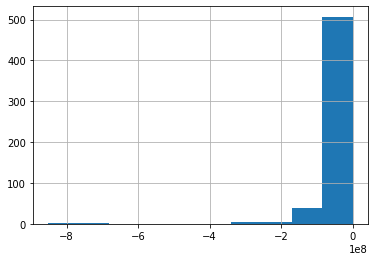

In [66]:
df[(df.WDL_AMT < 0)].shape
df[(df.WDL_AMT < 0)].WDL_AMT.hist()

In [72]:
df[(df.WDL_AMT < 0)].DATE.dt.month.value_counts()

1     325
2     226
3       3
11      1
7       1
4       1
Name: DATE, dtype: int64

In [73]:
df[(df.WDL_AMT >= 0)].DATE.dt.month.value_counts()

12    68901
10    68445
7     68026
8     67768
5     67185
11    66344
9     65536
6     64950
3     63944
4     63195
1     59359
2     57940
Name: DATE, dtype: int64

In [75]:
df[(df.WDL_AMT < 0)]

,TID,WDL_AMT_OFFUS,WDL_AMT_ONUS,WDL_COUNT_OFFUS,WDL_COUNT_ONUS,WDL_AMT,WDL_COUNT,DATE
14,91010049,304500,-3907700,47,130,-3603200,177,2017-01-01
403,91017339,0,-1255020,0,2,-1255020,2,2017-01-01
493,91017684,134400,-274800,20,45,-140400,65,2017-01-01
770,91018469,330100,-98763600,54,97,-98433500,151,2017-01-01
799,91018569,35500,-9692020,9,61,-9656520,70,2017-01-01
...,...,...,...,...,...,...,...,...
163394,91019538,0,-34000,0,4,-34000,4,2017-03-21
165511,91019538,0,-8000,0,1,-8000,1,2017-03-22
186797,91010030,0,-200,0,3,-200,3,2017-04-02
445034,91018421,-3000,0,29,202,-3000,231,2017-07-30


In [110]:
fin.groupby(['file','DATE']).WDL_AMT.sum().to_csv('Checkme.csv')